In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
remote_data = xr.open_dataarray('http://tds.hycom.org/thredds/dodsC/GLBu0.08/expt_91.1/uv3z?water_u')
remote_data

<xarray.DataArray 'water_u' (time: 738, depth: 40, lat: 2001, lon: 4500)>
[265812840000 values with dtype=float32]
Dimensions without coordinates: time, depth, lat, lon
Attributes:
    long_name:      Eastward Water Velocity
    standard_name:  eastward_sea_water_velocity
    units:          m/s
    NAVO_code:      17

In [3]:
depths = np.array([0, 2, 4, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50,
                   60, 70, 80, 90, 100, 125, 150, 200, 250, 300, 350, 400,
                   500, 600, 700, 800, 900, 1000, 1250, 1500, 2000, 2500,
                   3000, 4000, 5000])
# SS El Faro draft is approximately 13m. Average the data from the surface
# to 12 meters (0:6)
# https://en.wikipedia.org/wiki/SS_El_Faro
depth_dim = depths[0:6]
da = remote_data.isel(depth=slice(0, 6))

In [4]:
# Find region of interest (30.5/-81.5/18/-65.5) # Small region
#reg = [30.5, -81.5, 18.0, -65.5]; fname = 'HyCOM_small.nc'
# Find region of interest (30.5/-90.5/18/-30.0) # Big region
reg = [30.5, -90.5, 18.0, -30.5]; fname = 'HyCOM_big.nc'
# make psudo lon and lat and coords aren't read in properly
plon = np.linspace(0,360-(360./len(da.lon)),num=len(da.lon))
plat = np.linspace(-80,80,num=len(da.lat))

lonw = np.abs(plon - (360 + reg[1])).argmin()
lone = np.abs(plon - (360 + reg[3])).argmin()
latn = np.abs(plat - reg[0]).argmin()
lats = np.abs(plat - reg[2]).argmin()
latdim = plat[lats:latn]
londim = plon[lonw:lone]

print(lonw, lone, lats, latn)

3369 4119 1225 1381


In [5]:
da2 = da.isel(lat=slice(lats, latn), lon=slice(lonw, lone))

In [7]:
# make pseudo time as coords aren't read in
# Daily missing days
# https://hycom.org/faqs/463-nrl-netcdf-outputs-missing-days
missingdays = ['2015-09-19', '2015-03-25', '2015-03-15', '2015-01-02', '2014-04-13']
# First time point is 2014-04-07T00:00:00Z. Last time points is 2016-04-18T00:00:00Z
times = pd.date_range(start='04/07/2014',  end='04/18/2016', freq='D')
# Drop these time values
for i, t in enumerate(missingdays):
    _loc = times.get_loc(missingdays[i])
    times = times.drop(times[_loc])
    
# Select Sep 29th - October 3rd
#_st_et = ['2015-09-29', '2015-10-03']
# Select Sep 27th - October 5rd
_st_et = ['2015-09-27', '2015-10-05']

ts = times.get_loc(_st_et[0])
te = times.get_loc(_st_et[1])+1
timedim = times[ts:te]
print(ts, te)

533 542


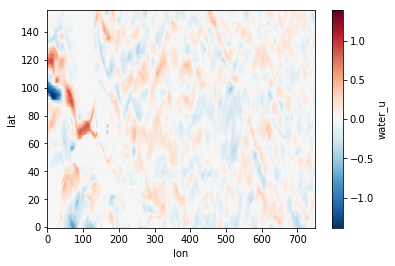

In [8]:
dau = da2.isel(time=slice(ts, te))
dau_avg = dau.mean(dim='depth')
dau_avg.isel(time=0).plot()

In [10]:
remote_data = xr.open_dataarray('http://tds.hycom.org/thredds/dodsC/GLBu0.08/expt_91.1/uv3z?water_v')
dav = remote_data.isel(depth=slice(0, 6), lat=slice(lats, latn), lon=slice(lonw, lone), time=slice(ts, te))
dav_avg = dav.mean(dim='depth')
print(dav_avg)

<xarray.DataArray 'water_v' (time: 9, lat: 156, lon: 750)>
array([[[      nan,       nan, ..., -0.003833,  0.062167],
        [      nan,       nan, ...,  0.023833,  0.091667],
        ...,
        [      nan,       nan, ..., -0.031667, -0.044833],
        [      nan,       nan, ..., -0.095333, -0.103667]],

       [[ 0.      ,  0.      , ..., -0.067167, -0.0435  ],
        [ 0.      ,  0.      , ..., -0.051   , -0.016833],
        ...,
        [ 0.      ,  0.      , ...,  0.015167,  0.007   ],
        [ 0.      ,  0.      , ...,  0.002833, -0.002833]],

       ...,

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.     

In [11]:
# save file
_dau = xr.DataArray(dau_avg.values, coords=[timedim, latdim, londim], dims=['time', 'lat', 'lon'])
_dav = xr.DataArray(dav_avg.values, coords=[timedim, latdim, londim], dims=['time', 'lat', 'lon'])
ds = xr.Dataset({'u': _dau, 'v': _dav})
ds.to_netcdf(fname)
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 156, lon: 750, time: 9)
Coordinates:
  * time     (time) datetime64[ns] 2015-09-27 2015-09-28 2015-09-29 ...
  * lat      (lat) float64 18.0 18.08 18.16 18.24 18.32 18.4 18.48 18.56 ...
  * lon      (lon) float64 269.5 269.6 269.7 269.8 269.8 269.9 270.0 270.1 ...
Data variables:
    u        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    v        (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
